<a href="https://colab.research.google.com/github/mrfabien/MLEE_project/blob/main/Europe_windsv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

A few librairies are going to be used, so let's install them. For panda, you'll need to restart the kernel to update it, otherwise it won't work.

In [1]:
# Panda version needs to be higher than 1.4.1 to extract the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV

pd.__version__ 
sklearn.__version__
%pip install pandas==1.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data preparation

Since the dataset is split into 2, one for moderate winds and the other dfor extreme winds. Let's merge them

In [2]:
# Path of the dataset

path_75 = '/content/drive/MyDrive/MLEE/df_europewinds_75.pkl'
path_95 = '/content/drive/MyDrive/MLEE/df_europewinds_95.pkl'

In [3]:
data_75 = pd.read_pickle(open(path_75, 'rb'))
data_75.head()

,year,index,bss0_1_mean,bss0_1_std,bss0_6_mean,bss0_6_std,rh1000_850_mean,rh1000_850_std,rh700_500_mean,rh700_500_std,...,lapse_s1_mean,lapse_s1_std,lapse700_500_mean,lapse700_500_std,total_totals_mean,total_totals_std,kindex_mean,kindex_std,cape_mean,cape_std
0,0,0,5.566746,1.409852,20.841965,2.403776,38.471111,5.528201,39.340164,4.507432,...,3.937160,1.835161,7.434533,0.157927,-223.870316,2.545162,-241.414597,1.920714,1.470943e+06,47421.042969
1,0,1,9.117043,2.212430,15.022616,1.769653,91.150574,4.519768,95.393280,3.446400,...,6.827473,0.361492,4.986881,0.123315,-230.567856,1.326195,-256.065704,2.432208,7.463997e+05,29720.560547
2,0,1,3.349157,1.543636,14.397669,1.997612,94.999939,3.762975,96.936325,2.179418,...,7.025648,0.705598,5.416773,0.279987,-229.407089,0.455871,-254.261292,0.960245,7.808471e+05,32203.679688
3,0,1,3.522637,1.343964,6.980061,1.558338,86.109894,6.356337,87.546326,8.126277,...,6.696632,0.315548,6.247573,0.096321,-225.117264,0.556208,-242.131607,0.737710,3.299286e+05,44017.738281
4,0,1,2.906259,1.306351,18.640661,0.778727,76.630363,11.766706,75.178864,5.603858,...,5.132456,0.965875,6.791603,0.163507,-221.258957,0.740583,-236.590332,0.754513,8.468746e+05,69275.562500


In [4]:
data_95 = pd.read_pickle(open(path_95, 'rb'))
data_95.head()

,year,index,bss0_1_mean,bss0_1_std,bss0_6_mean,bss0_6_std,rh1000_850_mean,rh1000_850_std,rh700_500_mean,rh700_500_std,...,lapse_s1_mean,lapse_s1_std,lapse700_500_mean,lapse700_500_std,total_totals_mean,total_totals_std,kindex_mean,kindex_std,cape_mean,cape_std
0,0,0,4.277383,1.872966,8.982351,0.724258,93.492226,5.035859,88.534180,5.347477,...,6.906764,1.327869,6.136250,0.066148,-229.698380,2.886750,-253.835098,3.049098,2.026168e+05,14708.218750
1,0,0,1.802277,0.753601,15.204497,0.530935,59.056320,1.762953,41.138809,20.166151,...,7.818282,0.271740,6.264568,0.162757,-229.545853,2.025261,-257.027924,5.805379,1.180107e+06,50493.390625
2,0,0,0.715803,0.243926,16.503664,0.667165,59.690506,3.856417,24.401155,8.628385,...,7.912159,0.212544,6.037870,0.176981,-230.075562,1.594442,-261.277252,2.990737,1.271284e+06,24269.503906
3,0,0,1.606050,1.158768,18.095135,1.584871,29.221788,1.806868,54.221584,3.082348,...,7.784466,0.688592,8.378917,0.154145,-220.908508,0.992791,-244.325333,1.691479,1.316592e+06,54253.433594
4,0,0,0.307757,0.309118,13.387435,1.153533,29.046917,3.302094,55.367680,3.316934,...,6.988350,0.134230,8.529189,0.123378,-221.513565,0.656967,-246.688919,0.659492,1.148537e+06,25503.769531


We need to create a new column to know whether or not it was a moderate wind or an extreme wind.

In [5]:
# Intensity 1 means extreme convective winds bursts and 0 means moderate convective bursts

data_75['intensity']=0
data_95['intensity']=1

In [6]:
# Merge the 2 dataset and separate the features from the intensity

data_merged = pd.concat((data_75,data_95))
y = data_merged['intensity']
X = data_merged.iloc[:,2:-1]

In [7]:
# Store the name of each feature

features_names = data_merged.columns[2:-1]

# Data splitting

Separation of the dataset in to 3, with one for training, one for testing and one for validation

In [8]:
# Split the dataset into a training (64%), validation (16%), and testing set (20%)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, train_size=0.8)

In [41]:
# Split the dataset into only training and validation (80% and 20%) and along the years. 
# LATER --> So the 80% of the training will be from 2011 to 2018 and the validation from 2018 to 2020

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, shuffle=True)

# 1st algorithm : Logistic Regression

In [42]:
# Let's try to predict the 2 classes of winds bursts with Logistic Regression  

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [43]:
# Let's try a prediction

prediction_lr = lr.predict(X_test)

lr_accuracy = accuracy_score(y_test, prediction_lr)  

print(f"LR Model Accuracy: {lr_accuracy:.2%}")

LR Model Accuracy: 57.71%


In [44]:
# The accuracy is not good, less than 60%, so let's try to adujst the solver

lr2 = LogisticRegression(solver="liblinear")
lr2.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [45]:
# Let's try a prediction

prediction2_lr = lr2.predict(X_test)
lr2_accuracy = accuracy_score(y_test, prediction2_lr)  

print(f"LR Model Accuracy: {lr2_accuracy:.2%}")

LR Model Accuracy: 59.35%


In [46]:
# The accuracy is still not good, just above 60%. Let's see the feature importance

print(lr2.coef_)
np.shape(lr2.coef_)

[[ 1.11618140e-02  2.15130807e-03 -1.25772725e-04  1.48737811e-03
   1.24985851e-02 -3.67435333e-03  1.06872361e-02  7.46400644e-05
   1.19263619e-03  8.99332975e-05 -1.65283471e-03 -3.31649368e-04
  -1.21047107e-03  3.89747863e-05  7.41633724e-03  9.67764997e-05
   3.83103888e-03  3.65646735e-04  3.08376593e-07  1.00928371e-06]]


(1, 20)

In [47]:
# Calculation of the standard deviation

std_train = X_train.std(axis=0)

<BarContainer object of 20 artists>

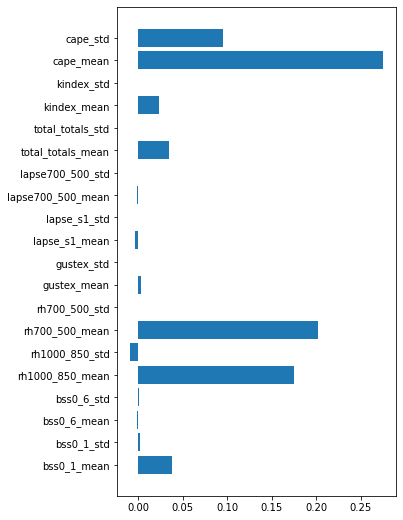

In [48]:
# Graphic of the feature importance

features_importance = std_train*lr2.coef_[0,:]

fig, ax = plt.subplots(1,1, figsize=(5,9))
ax.barh(features_names,features_importance)

# 2nd algorithm: Random Forest


In [49]:
# Now let's try with RandomForest

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [50]:
# Let's see if the predictions are better than the Logistic Regression

prediction_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, prediction_rf)

print(f"RF Model Accuracy: {rf_accuracy:.2%}")

RF Model Accuracy: 66.06%


In [53]:
# Better from the first try, let's try to improve it

rf2 = RandomForestClassifier(n_estimators=300,
                             verbose=3)
rf2.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   45.9s finished


RandomForestClassifier(n_estimators=300, verbose=3)

In [19]:
# Let's see if the predictions are better than the previous one

prediction_rf2 = rf2.predict(X_test)
rf2_accuracy = accuracy_score(y_test, prediction_rf2)

print(f"RF Model Accuracy: {rf2_accuracy:.2%}")

RF Model Accuracy: 66.34%


In [44]:
# WARNING: THIS CELL TAKES AGES TO RUN, DON'T RUN IT, try sequentialfeatureselection, 
# ML algorithm to try https://journals.ametsoc.org/view/journals/wefo/32/6/waf-d-17-0038_1.xml?tab_body=pdf

# Tune of the hyperparameters for the Random Forest with parameters
# For 'max_leaf_nodes', let's search between 2 and 120 and for 'min_samples_split', let's search between 2 and 10

# param_grid helps to define the hyperparameters you would like to test, and the ranges the hyperparameters should be in
'''param_grid = {'max_leaf_nodes':range(30,80),
              'min_samples_split':range(2,10)}

# Then, perform the GridSearch on the RandomForest

rsc_rf = HalvingRandomSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=10,verbose=3)

# Next, try a new fit with the training data

rsc_rf.fit(X_train,y_train)'''

sfs = SequentialFeatureSelector(rf, n_features_to_select=4, cv=3, n_jobs=3)
sfs.fit(X_train,y_train)

SequentialFeatureSelector(cv=3, estimator=RandomForestClassifier(),
                          n_features_to_select=4, n_jobs=3)

In [101]:
# Best estimators are the following:
selected_features = sfs.support_
selected_features  = np.array(X_train.columns)[np.array(selected_features)]
X_train_reduced = X_train[X_train.columns.intersection(selected_features)]
X_test_reduced = X_test[X_test.columns.intersection(selected_features)]


In [102]:
rf3 = RandomForestClassifier(n_estimators=300)
rf3.fit(X_train_reduced,y_train)

RandomForestClassifier(n_estimators=300)

In [104]:
# Let's see the prediction from the tuned RF

prediction_rf3 = rf3.predict(X_test_reduced)
sfs_accuracy = accuracy_score(y_test, prediction_rf3)

print(f"RF Model Accuracy: {sfs_accuracy:.2%}")

RF Model Accuracy: 60.88%


In [23]:
# Now let's compare it with prediction based on the training and testing set

y_pred_train = rsc_rf.predict(X_train)
print(f'Accuracy over training set: {(accuracy_score(y_train,y_pred_train)):.2%} \n' 
f'Accuracy over test set: {(accuracy_score(y_test,prediction_rf3)):.2%}')

Accuracy over training set: 69.87% 
Accuracy over test set: 64.77%


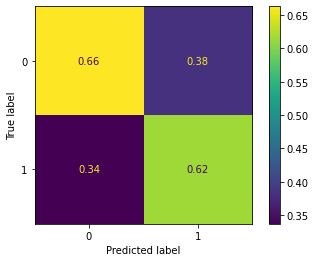

In [24]:
# Results are barely better than the first try with RF, let's see the confusion matrix

cm = confusion_matrix(y_test, prediction_rf3, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [25]:
# Since the performance are not clearly better than the LR, let's see what features are important for the RF
# The following cell was copied from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# This cell mainly extract the importances of each feature and standardized them
# It also check how much time it takes

import time

start_time = time.time()
importances = rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.087 seconds


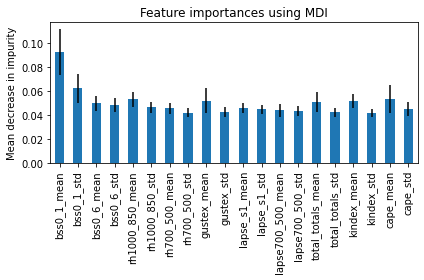

In [26]:
# Let's see the features importance
# This cell was copied also from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

forest_importances = pd.Series(importances, index=features_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [27]:
# Let's try to permute the features and see how the model refit them
# Again, this was copied from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=features_names)

Elapsed time to compute the importances: 32.366 seconds


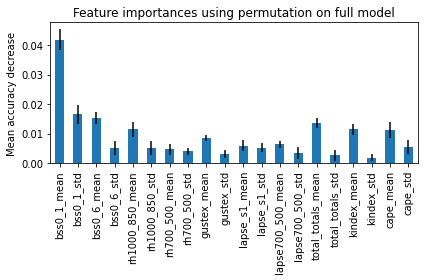

In [28]:
# Let's see the results. The higher the bar is, the more important the feature is

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()